# Machine Learning I, Programming Exercise 1

## 1. SVM Basics
Before we actually attempt to implement a support vector machine algorithm ourselves, it makes sense to play around with the reference implementation from Scikit-Learn. That way, we get to know what kind of behaviour we can and should expect from a working implementation.

1. Let $\{x \in \mathbb{R}^2 \mid \mathbf{w}^T\mathbf{x} + b = 0\}$ be a hyperplane (i.e., a line). Write a function that takes arguments $\mathbf{x}^{(1)}_1, \mathbf{x}^{(2)}_1, \ldots, \mathbf{x}^{(n)}_1 \in \mathbb{R}$, $\mathbf{w} \in \mathbb{R}^2$ and $b \in \mathbb{R}$ and returns $\mathbf{x}^{(1)}_2, \mathbf{x}^{(2)}_2, \ldots, \mathbf{x}^{(n)}_2 \in \mathbb{R}$ s.t.
\begin{equation*}
    \mathbf{w}^T \left(\begin{matrix} \mathbf{x}^{(i)}_1 \\ \mathbf{x}^{(i)}_2 \end{matrix}\right) + b = 0.
\end{equation*}
You can use this function to easily draw line segments from the line defined by $\mathbf{w}$ and $b$.
2. Train an SVM (Scikit-Learn's [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) class) on both datasets generated in the code skeleton. Choose `kernel='linear'` in order to get a linear classifier.
3. Draw the decision surface of the SVM. After you have trained the SVM you can access $\mathbf{w}$ and $b$ via `SVC.coef_` and `SVC.intercept_`, respectively.
4. Play around with the value of $C$ and see how that changes the decsion surface.
5. Implement a function that computes the signed distance between a set of points $\mathbf{x}_1, \mathbf{x}_2, \ldots$ and the hyperplane defined by $\mathbf{w}$ and $b$. Use this to compute the signed distance between all datapoints and the decision surface of the SVM and multiply the result with the class label ($\{-1, 1\}$) of the datapoint. The points with minimal but non-negative value are the support vectors.
6. Based on the support vector(s), draw the margin of the SVM as two lines parallel to the decision surface. One of them must contain the support vector, while the other line needs to be on the opposite side of the decision boundary.
7. Pick two or three datapoints from each class and flip their label. How does the SVM react to those outliers? Train it again on this dataset and observe what happens for different values of $C$.

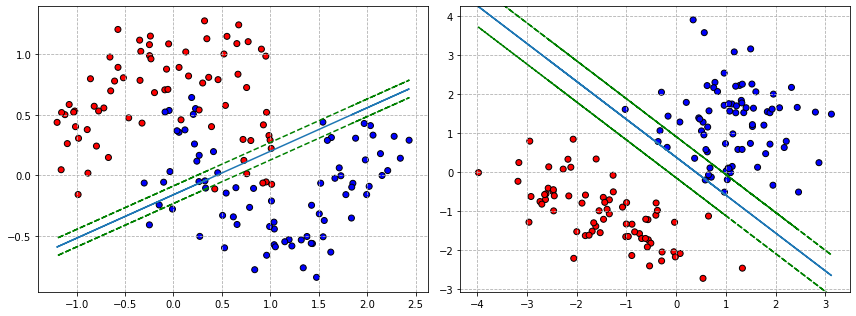

In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


def apply_line(x, w, b):
    w = w[0]
    slope = -w[0] / w[1]
    y = slope * x + (b[0] / w[1])
    return y 
    
    

def signed_distance(x, w, b):
    w_mag = np.sqrt(np.sum(np.square(w)))
    distance = (1/w_mag) * (np.dot(w, x.T) + b)
    return distance
        
    

    
# Generate toy data
n = 200
X_moon, Y_moon = datasets.make_moons(n, noise=0.2, random_state=123456)
X_blob, Y_blob = datasets.make_classification(n, n_features=2, n_redundant=0, 
                                              n_clusters_per_class=1, class_sep=1.2, random_state=12345)
# Change labels from 0,1 to -1,1
Y_moon *= 2; Y_moon -= 1
Y_blob *= 2; Y_blob -= 1


# Plot the datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
cmap = ListedColormap([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
for (name, X, Y), ax in zip([('Two Moons', X_moon, Y_moon), ('Blobs', X_blob, Y_blob)], axes):
    # Plot training Data
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap, edgecolor='k')
    ax.grid(linestyle='dashed')
    ax.set_autoscale_on(False)
    
    # TODO: Train and visualize the SVM
    model = SVC(kernel='linear', C=1.0)
    model.fit(X_train, Y_train)
    #Y_predicted = model.predict(X_test)
    #
    line = apply_line(X_train[:, 0], model.coef_, model.intercept_)
    ax.plot(X_train[:, 0], line)
    signed_distance_ = signed_distance(X_train, model.coef_, model.intercept_) 
    
    ax.plot(X_train[:, 0], line + min(signed_distance_[signed_distance_ > 0]), color="g", linestyle='--')
    ax.plot(X_train[:, 0], line - min(signed_distance_[signed_distance_ > 0]), color="g", linestyle='--')
    
fig.tight_layout()
plt.show()
plt.close(fig)

## 2. Nearest Centroid Classifier
Given a dataset $D = \{(\mathbf{x}^{(1)}, y^{(1)}), (\mathbf{x}^{(2)}, y^{(2)}), \ldots, (\mathbf{x}^{(n)}, y^{(n)})\}$ with labels $y \in \{-, +\}$, we can separate the dataset per class, i.e., $D_- = \{(\mathbf{x}, y) \in D \mid y=-\}$ and $D_+ = \{(\mathbf{x}, y) \in D \mid y=+\}$ and compute the centroids for each class:
\begin{equation*}
    \mathbf{c}_- = \frac{1}{\lvert D_- \rvert} \sum_{(\mathbf{x}, y) \in D_-} \mathbf{x} \qquad\qquad \mathbf{c}_+ = \frac{1}{\lvert D_+ \rvert} \sum_{(\mathbf{x}, y) \in D_+} \mathbf{x}.
\end{equation*}
The nearest centroid classifier $f$ is then defined as follows:
\begin{equation*}
    f(\mathbf{x}) := \operatorname{arg\ min}_{y \in \{-,+\}} \lVert \mathbf{x} - \mathbf{c}_y \rVert
\end{equation*}

In this exercises we will implement the Nearest Centroid Classifier (NCC) and run it on two generated toy datasets. Please keep in mind that Scikit-learn returns labels in $\{0,1\}$, which might become a problem depending on the way you decide to implement the NCC.
1. Write a function that takes a dataset $D$ and returns the centroids $\mathbf{c}_-$ and $\mathbf{c}_+$.
2. Then use these centroids to implement the nearest centroid classifier.
3. Draw the decision surface defined by $f(\mathbf{x}) = 0$ into the corresponding scatterplot that is already created by the code skeleton. Also plot and highlight the centroids and draw a line between them.
4. Compute the accuracy of the NCC on the held-out test dataset. Can you find a way to improve it without actuallly modifying the NCC algorithm itself? (Hint: Take a look at part 3 of the last notebook)

[ 1.05815362 -0.10854632] [-0.05485157  0.6229113 ]
w:  [ 2.22601039 -1.46291524]
b:  -0.7404442072512871
              precision    recall  f1-score   support

           0       0.75      0.78      0.76        27
           1       0.73      0.70      0.71        23

    accuracy                           0.74        50
   macro avg       0.74      0.74      0.74        50
weighted avg       0.74      0.74      0.74        50

[[21  6]
 [ 7 16]]
[-1.08287937  1.0920964 ] [0.99764582 0.90512804]
w:  [-4.16105037  0.37393671]
b:  -0.5507483110068003
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        31
           1       0.81      0.68      0.74        19

    accuracy                           0.82        50
   macro avg       0.82      0.79      0.80        50
weighted avg       0.82      0.82      0.82        50

[[28  3]
 [ 6 13]]


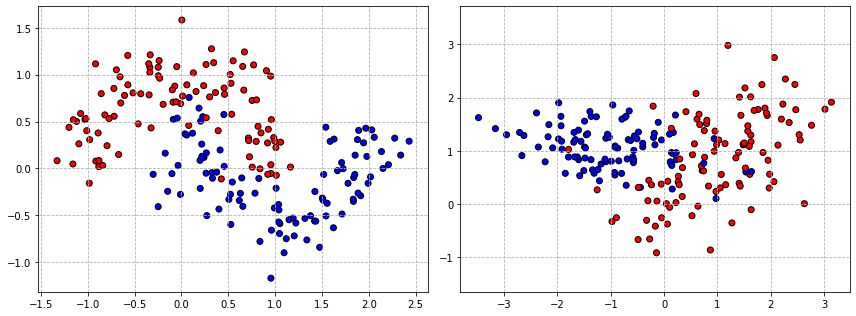

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, confusion_matrix

def find_centroid(coor):
    
    length_ = coor.shape[0]
    centroid = np.sum(coor, axis=0) /length_
    return centroid

def compute_centroids(X, y):
    #raise NotImplementedException('TODO') 
    #import pdb; pdb.set_trace()
    y = y.reshape(-1, 1)
    x_y = np.concatenate((X, y), axis=1)
    centroid_1 =find_centroid(x_y[x_y[:, 2]>0][:,:2])
    centroid_2 = find_centroid(x_y[x_y[:, 2]<=0][:,:2])
    print(centroid_1, centroid_2 )
    return centroid_1, centroid_2 

class NCC(BaseEstimator, ClassifierMixin):
    def __init__(self):
        super(NCC, self).__init__()
        self.centroid_1 = None
        self.centroid_2 = None
        self.w = None
        self.b = None
        
    def fit(self, X, y):
        self.centroid_1, self.centroid_2 = compute_centroids(X, y)
        self.w = 2*(self.centroid_1 - self.centroid_2)
        self.b = sum(self.centroid_2**2) - sum(self.centroid_1**2)
        print("w: ", self.w)
        print("b: ", self.b)

    def predict(self, X):
        y_out = np.dot(self.w, X.T) + self.b
        return [1 if item >0.5 else 0 for item in y_out]

    
# Generate toy data
n = 200
X_moon, Y_moon = datasets.make_moons(n, noise=0.2, random_state=123456)
X_blob, Y_blob = datasets.make_classification(n, n_features=2, n_redundant=0, 
                                              n_clusters_per_class=1, random_state=234567)

# Plot the datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
cmap = ListedColormap([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
for (name, X, Y), ax in zip([('Two Moons', X_moon, Y_moon), ('Blobs', X_blob, Y_blob)], axes):
    # Plot dataset
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap, edgecolor='k')
    ax.grid(linestyle='dashed')
    x_min, x_max, _, _ = ax.axis('equal')
    
    # TODO: Run and Visualize the NCC
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)
    
    ncc = NCC()
    ncc.fit(X_train, Y_train)
    y_predicted = ncc.predict(X_test)
    
    print(classification_report(Y_test, y_predicted))
    print(confusion_matrix(Y_test, y_predicted))

fig.tight_layout()
plt.show()
plt.close(fig)

In [ ]:
x_y = np.concatenate((X, y), axis=1)
